In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib_inline
import os
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm 
import seaborn as sns
from PIL import Image
from numpy import asarray

np.set_printoptions(precision=5)#show 5 number after decimal point 

In [63]:
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

In [64]:
url = r"C:\\Users\\noa12\\OneDrive\\מסמכים\\GitHub\\Dogs_Vs_Cats_Project\\train\\"

In [18]:
def create_data():
    data = list()
    label = 0 #cat = 1 , dog = 0
    for img in tqdm(os.listdir(url)):
        if img.startswith('cat'): label = 1 
        else :label = 0 
        im = asarray(Image.open(url+img).resize((55,55)).convert('L')) #resize and changing colors
        data.append([im,label])
    np.save('data.npy', data)
    return data

In [19]:
data = create_data()

100%|████████████████████████████████████████████████████████████████████████████| 25000/25000 [05:04<00:00, 82.16it/s]


In [65]:
# load the data:
data = np.load('data.npy',allow_pickle=True)

In [66]:
X = (np.array([i[0] for i in data]))
Y = (np.array([i[1] for i in data]))

In [67]:
X = X /255.0

In [68]:
X.shape

(25000, 55, 55)

In [69]:
X = X.reshape((25000, 55*55))
X.shape

(25000, 3025)

In [70]:
from sklearn.model_selection import train_test_split

#split the data to train and test 
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.1, random_state=42)

In [71]:
#split the train
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train, test_size=0.1, random_state=42)

In [72]:
# Before we try real models, we will try a dummyClassifier. we will try to get high score than the dummyModel.
from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier(strategy="most_frequent", random_state=42)
dummy_clf.fit(X_train, y_train)
y_pred = dummy_clf.predict(X_val)
print("The DummyClassifier score is:" ,round(accuracy_score(y_pred,y_val),3))

The DummyClassifier score is: 0.503


## Models : 


### Feature selection: 

>The best score of the model was with 2150 feature - We will use this number of features for the other models as well.

In [73]:
X_train.shape

(20250, 3025)

#### RandomForestClassifier :

In [74]:
%%time

from sklearn.ensemble import RandomForestClassifier

RF = RandomForestClassifier(random_state=42)
RF.fit(X_train, y_train)
y_pred_RF = RF.predict(X_val)
accuracy = round(metrics.accuracy_score(y_pred_RF,y_val),3)
print("Accuracy:", accuracy)

Accuracy: 0.642
CPU times: total: 4min 6s
Wall time: 4min 7s


In [75]:
%%time
from sklearn.ensemble import RandomForestClassifier

kf= KFold(n_splits=3, random_state=42, shuffle=True)
RForest = RandomForestClassifier(random_state=42)
random_forest= cross_val_score(RForest, X_new,y_train, cv=kf, scoring='accuracy').mean()
print(round(random_forest,3))

0.636
CPU times: total: 6min 21s
Wall time: 6min 22s


##### XGBClassifier:

In [76]:
%%time

from xgboost import XGBClassifier

XGBoost = XGBClassifier(objective="binary:logistic", random_state=42)
XGBoost.fit(X_train, y_train, eval_metric='auc')
y_pred_XGB = XGBoost.predict(X_val)

accuracy = round(metrics.accuracy_score(y_val, y_pred_XGB),3)
print("Accuracy:", accuracy)

Accuracy: 0.669
CPU times: total: 20min 15s
Wall time: 3min 1s


[8.62666e-05 0.00000e+00 2.21149e-04 ... 4.92497e-04 5.31248e-04
 1.47759e-03]


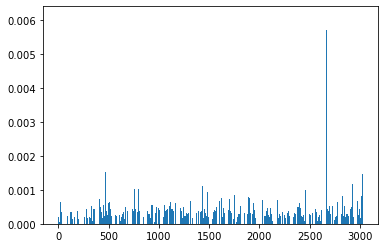

In [77]:
from matplotlib import pyplot
print(XGBoost.feature_importances_)
# plot
pyplot.bar(range(len(XGBoost.feature_importances_)), XGBoost.feature_importances_)
pyplot.show()

In [78]:
XGBoost.feature_importances_.max()

0.0060928506

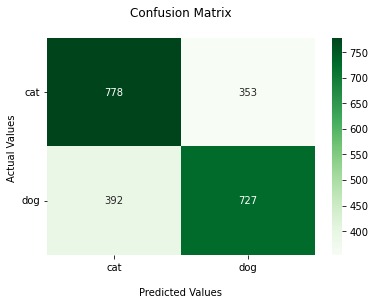

In [79]:
from sklearn.metrics import confusion_matrix

cf_matrix = confusion_matrix(y_val, y_pred_XGB)
fig, ax = plt.subplots(figsize=(6,4))
ax = sns.heatmap(cf_matrix, annot=True, fmt='', cmap='Greens')
ax.set_title('Confusion Matrix\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
ax.xaxis.set_ticklabels(["cat","dog"])
ax.yaxis.set_ticklabels(["cat","dog"],rotation=0)

plt.show()

In [80]:
%%time
from xgboost import XGBClassifier
from sklearn.feature_selection import SelectKBest

kf= KFold(n_splits=5, random_state=42, shuffle=True)
XGBClassifier = XGBClassifier(objective="binary:logistic", random_state=42,eval_metric='auc')
XGB = cross_val_score(XGBClassifier, X_train,y_train, cv=kf, scoring='accuracy').mean()
print(XGB)

0.6555061728395062
CPU times: total: 1h 29min 56s
Wall time: 13min 8s


#### AdaBoostClassifier

In [81]:
%%time
from sklearn.ensemble import AdaBoostClassifier

AdB = AdaBoostClassifier()
AdB.fit(X_train, y_train)
y_pred = AdB.predict(X_val)

accuracy = round(metrics.accuracy_score(y_val, y_pred),3)
print("Accuracy:", accuracy)
#print("Classification Report: \n", metrics.classification_report(y_test, y_pred))

Accuracy: 0.601
CPU times: total: 6min 24s
Wall time: 6min 24s


In [82]:
%%time
from sklearn.ensemble import AdaBoostClassifier

kf= KFold(n_splits=3, random_state=42, shuffle=True)
AdaBoost = AdaBoostClassifier()
AdB = cross_val_score(AdaBoost, X_train,y_train, cv=kf, scoring='accuracy').mean()
print(AdB)


0.5813827160493826
CPU times: total: 9min 17s
Wall time: 9min 19s


### GradientBoostingClassifier

In [83]:
from sklearn.ensemble import GradientBoostingClassifier

GBC = GradientBoostingClassifier(verbose=1).fit(X_train, y_train)
y_pred = GBC.predict(X_val)

accuracy = round(metrics.accuracy_score(y_val, y_pred),3)
print("Accuracy:", accuracy)
#print("Classification Report: \n", metrics.classification_report(y_test, y_pred))    

      Iter       Train Loss   Remaining Time 
         1           1.3795           25.98m
         2           1.3731           25.17m
         3           1.3676           24.98m
         4           1.3624           24.75m
         5           1.3575           24.57m
         6           1.3532           24.39m
         7           1.3484           24.00m
         8           1.3444           23.72m
         9           1.3397           23.50m
        10           1.3365           23.26m
        20           1.3048           20.69m
        30           1.2798           17.98m
        40           1.2608           15.31m
        50           1.2447           12.70m
        60           1.2292           10.18m
        70           1.2160            7.64m
        80           1.2028            5.08m
        90           1.1910            2.55m
       100           1.1777            0.00s
Accuracy: 0.653


### Hyperparameter Tuning: 

In [84]:
#Searching for better performance out of the models with RandomizedSearch
from sklearn.model_selection import RandomizedSearchCV

In [85]:
#XGBClassifier
from xgboost import XGBClassifier
parameters = {
        'learning_rate': [ 0.1,0.3,0.03],
        'max_depth': [5,6,10],
        'min_child_weight': [1, 2],
        'subsample': [0.5,0.6,1],
        'colsample_bytree': [0.3,0.5, 0.7],
        'n_estimators' : [100,150,170,200]
         }

random_XGB = RandomizedSearchCV(XGBClassifier(),parameters, verbose=True, 
                          cv=3,random_state=42, return_train_score=True)
random_XGB.fit(X_train,y_train, eval_metric='auc')
y_pred_XGB_random = random_XGB.predict(X_val)
print ("Accuracy Score = ",round(metrics.accuracy_score(y_val,y_pred_XGB_random),3))
print (random_XGB.best_params_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Accuracy Score =  0.675
{'subsample': 1, 'n_estimators': 200, 'min_child_weight': 1, 'max_depth': 10, 'learning_rate': 0.03, 'colsample_bytree': 0.7}


In [86]:
random_XGB.best_params_

{'subsample': 1,
 'n_estimators': 200,
 'min_child_weight': 1,
 'max_depth': 10,
 'learning_rate': 0.03,
 'colsample_bytree': 0.7}